In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import scipy

import arviz as az

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
def f(x):
    return np.sin(20*x) + 2*np.cos(14*x) - 2*np.sin(6*x)

# dataset
x = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
y = f(x)

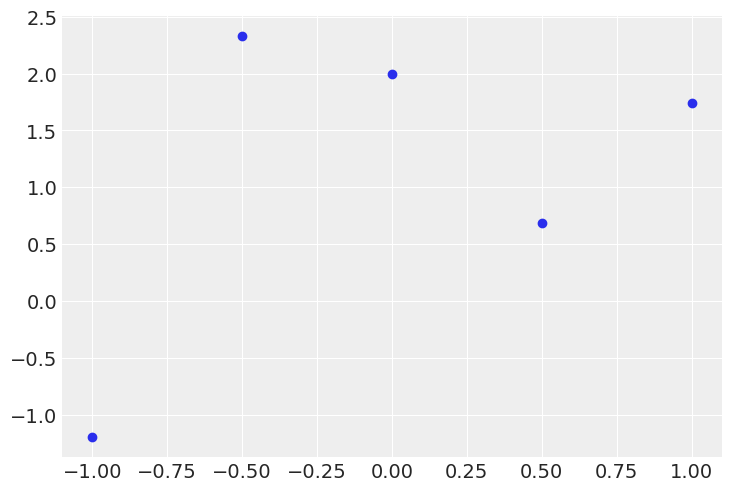

In [4]:
plt.scatter(x, y)

/var/folders/j4/79pszr2s63x4pyfdwfp6509r0000gp/T/ipykernel_9242/3445400308.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))
Sample: 100%|██████████| 1000/1000 [00:17, 58.10it/s, step size=4.36e-01, acc. prob=0.859]


array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

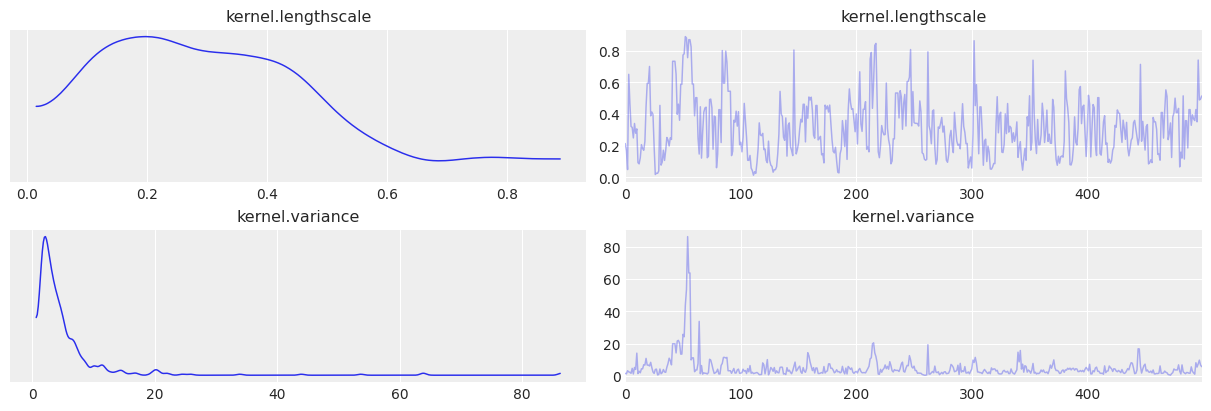

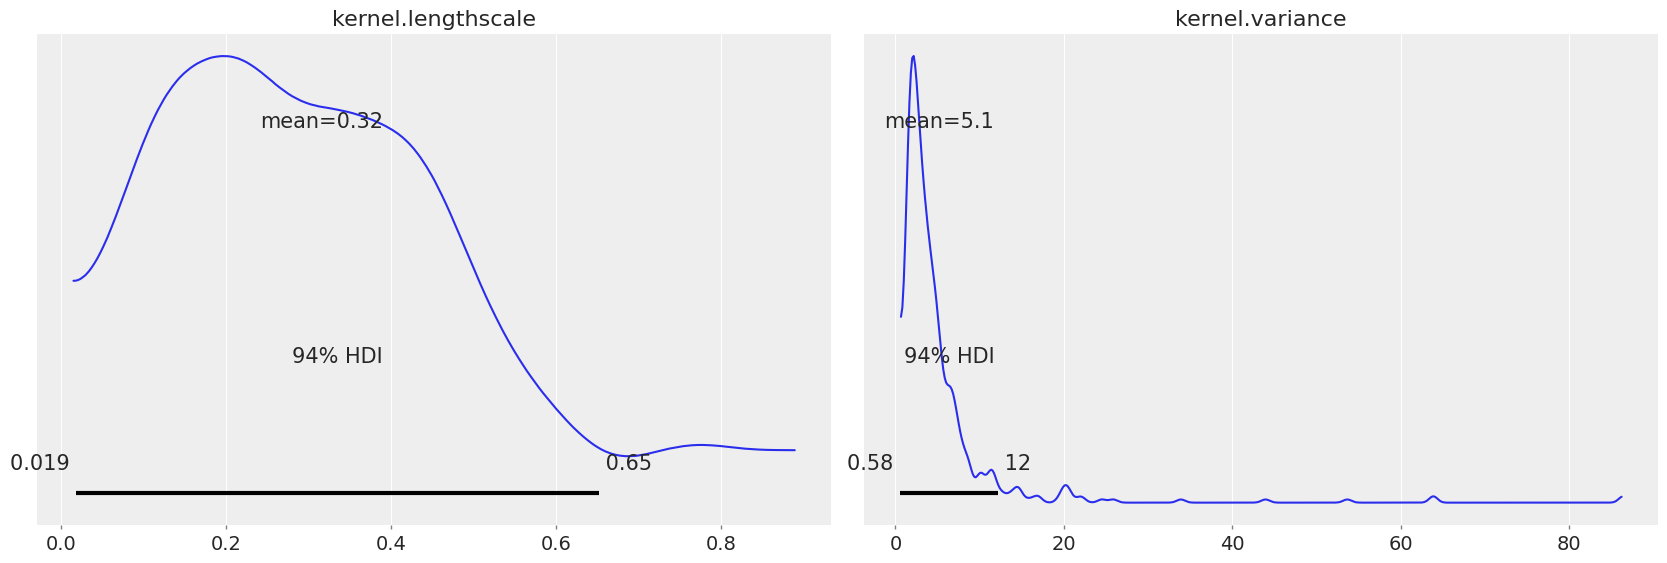

In [6]:
# trying with MCMCM
pyro.clear_param_store()

kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10.0)
)
gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))

nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=500)
mcmc.run()

posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_var = mcmc.get_samples()['kernel.variance']

az.plot_trace(mcmc.get_samples(),compact=False)
az.plot_posterior(mcmc.get_samples())

tensor([0.0142, 0.0142, 0.0142, 0.0142, 0.0142])


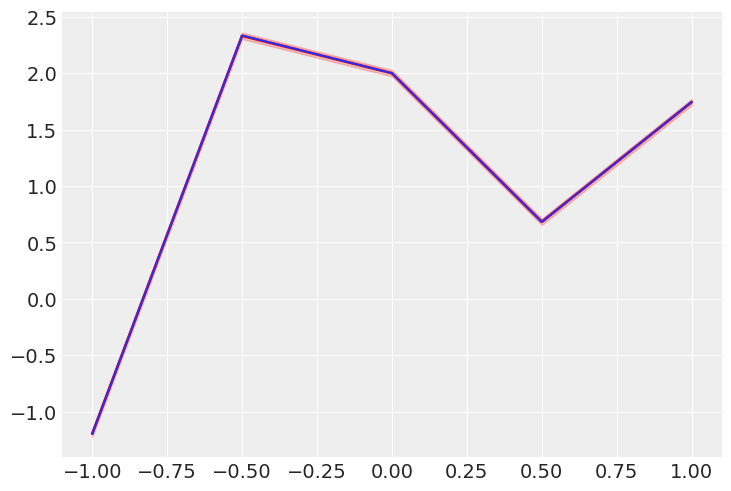

In [9]:
# compute predictive mean and variance
with torch.no_grad():
    mean, cov = gpr(x, full_cov=True, noiseless=False)

sd = cov.diag().sqrt()  # standard deviation at each input point x
plt.plot(x.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
plt.fill_between(
    x,  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * sd).numpy(),
    (mean + 2.0 * sd).numpy(),
    color="r",
    alpha=0.2,
)
plt.plot(x, y)
print(sd)

# Assignment B

In [ ]:
# compute predictive mean and variance

def f_star(x):
    with torch.no_grad():
        x = torch.tensor([x], dtype=torch.float32)
        print(x)
        mean, _ = gpr(x, full_cov=True, noiseless=False)
    
    return mean.numpy()

res = scipy.optimize.minimize_scalar(f_star, bounds=(-1.0, 1.0), method='bounded')
res

for i in range()

#f_star(0.4)

In [8]:
x_i, y_i = m.argmin(), m.min()
x_, y_ = torch.clone(x).detach(), torch.clone(y).detach()


x_ = torch.cat((x_, x_i.expand(1)), dim=0)
y_ = torch.cat((y_, y_i.expand(1)), dim=0)

NameError: name 'm' is not defined

In [27]:
x_ = torch.linspace(-1, 1, 1000)
with torch.no_grad():
    m, cov = gpr(x_, full_cov=True, noiseless=False)

sd = cov.diag().sqrt()  # standard deviation at each input point x
plt.plot(x.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
plt.fill_between(
    x,  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * sd).numpy(),
    (mean + 2.0 * sd).numpy(),
    color="r",
    alpha=0.2,
)
plt.plot(x, y)
print(sd)

In [14]:
m, v = gpr(torch.tensor([0.4]), full_cov=True, noiseless=False)

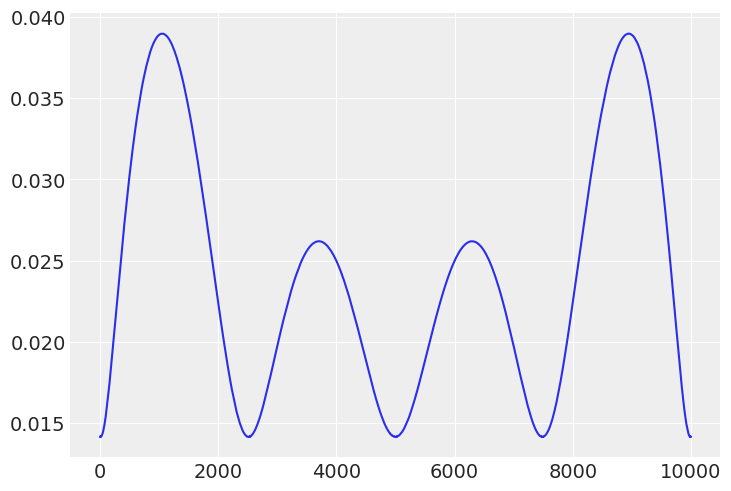

In [29]:
plt.plot(sd)


In [24]:
k = m.retain_grad()

In [26]:
k